# OCI Services Growth Trends & Sales Planning Analysis

**Objective:** Discover growth trends in OCI service consumption, identify expansion opportunities, and develop data-driven sales strategies for increased service adoption across the tenancy.

**Analysis Date:** December 2025
**Dataset:** output_merged.csv (merged billing and usage data)

---

## 📋 Table of Contents
1. Import Required Libraries
2. Load and Explore the Merged Dataset
3. Data Cleaning and Preprocessing
4. Time Series Analysis of Service Consumption
5. Growth Rate Calculations and Trends
6. Service-Level Consumption Patterns
7. Cost Analysis and Revenue Projections
8. Identify High-Growth Services
9. Regional and Compartment Analysis
10. Forecast Future Consumption
11. Generate Sales Recommendations and Insights
12. Key Metrics and Trends Visualization

## 1. Import Required Libraries

In [1]:
# Core data processing
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# Statistical and ML libraries
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_colwidth', 100)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ All libraries imported successfully")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully
📅 Analysis Date: 2025-12-11 22:34:23


## 2. Load and Explore the Merged Dataset

In [2]:
# Load the merged dataset
file = '../output/output_merged.csv'

try:
    df = pd.read_csv(file, low_memory=False)
    print(f"✅ Dataset loaded successfully from {file}")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    df = None

if df is not None:
    print(f"\n📊 Dataset Overview:")
    print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"   Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print(f"\n📅 Time Coverage:")
    print(f"   Date Range: {df['timeUsageStarted'].min()} to {df['timeUsageEnded'].max()}")
    
    print(f"\n💰 Financial Summary:")
    print(f"   Total Cost: ${df['computedAmount'].sum():,.2f}")
    print(f"   Average Cost per Row: ${df['computedAmount'].mean():,.2f}")
    
    print(f"\n📋 Key Dimensions:")
    print(f"   Unique Services: {df['service'].nunique()}")
    print(f"   Unique Regions: {df['region'].nunique()}")
    print(f"   Unique Compartments: {df['compartmentName'].nunique()}")
    print(f"   Unique SKUs: {df['skuName'].nunique()}")
    
    print(f"\n📊 Column Data Types:")
    print(df.dtypes)
    
    print(f"\n📊 First Few Rows:")
    df.head()

✅ Dataset loaded successfully from ../output/output_merged.csv

📊 Dataset Overview:
   Shape: 40,417 rows × 41 columns
   Memory Usage: 114.38 MB

📅 Time Coverage:
   Date Range: 2025-12-01T00:00:00.000Z to 2025-12-02T00:00:00.000Z

💰 Financial Summary:
   Total Cost: $12,791.95
   Average Cost per Row: $0.32

📋 Key Dimensions:
   Unique Services: 70
   Unique Regions: 0
   Unique Compartments: 0
   Unique SKUs: 272

📊 Column Data Types:
ad                          float64
attributedCost              float64
attributedUsage             float64
compartmentId               float64
compartmentName             float64
compartmentPath              object
computedAmount              float64
computedQuantity            float64
currency                     object
discount                    float64
isForecast                     bool
listRate                    float64
overage                     float64
overagesFlag                float64
platform                    float64
region            

## 3. Data Cleaning and Preprocessing

In [3]:
# Convert date columns to datetime
df['timeUsageStarted'] = pd.to_datetime(df['timeUsageStarted'])
df['timeUsageEnded'] = pd.to_datetime(df['timeUsageEnded'])

# Create date-based features
df['date'] = df['timeUsageStarted'].dt.date
df['year'] = df['timeUsageStarted'].dt.year
df['month'] = df['timeUsageStarted'].dt.month
df['year_month'] = df['timeUsageStarted'].dt.strftime('%Y-%m')
df['week'] = df['timeUsageStarted'].dt.isocalendar().week
df['day_of_week'] = df['timeUsageStarted'].dt.day_name()
df['day_of_month'] = df['timeUsageStarted'].dt.day
df['quarter'] = df['timeUsageStarted'].dt.quarter

# Fill missing values
df['service'] = df['service'].fillna('Unknown')
df['region'] = df['region'].fillna(df['region_from_call2']).fillna('Unknown')
df['compartmentName'] = df['compartmentName'].fillna(df['compartmentPath'].str.split('/').str[-1]).fillna('Unknown')
df['skuName'] = df['skuName'].fillna('Unknown SKU')
df['computedAmount'] = pd.to_numeric(df['computedAmount'], errors='coerce').fillna(0)
df['computedQuantity'] = pd.to_numeric(df['computedQuantity'], errors='coerce').fillna(0)

# Handle tags - parse JSON if available
def extract_tags(tag_str):
    try:
        if pd.isna(tag_str) or tag_str == '':
            return {}
        tags_list = json.loads(tag_str)
        return {tag['key']: tag['value'] for tag in tags_list if 'key' in tag and 'value' in tag}
    except:
        return {}

df['tags_dict'] = df['tags'].apply(extract_tags)
df['cost_center'] = df['tags_dict'].apply(lambda x: x.get('CostCenter', 'Untagged'))
df['environment'] = df['tags_dict'].apply(lambda x: x.get('Environment', 'Untagged'))
df['team'] = df['tags_dict'].apply(lambda x: x.get('Team', 'Untagged'))

# Remove duplicates if any
initial_rows = len(df)
df = df.drop_duplicates(subset=['timeUsageStarted', 'service', 'region', 'compartmentName', 'skuName', 'resourceId'])
print(f"✅ Removed {initial_rows - len(df):,} duplicate rows")

print(f"✅ Data cleaning completed")
print(f"📊 Final dataset: {len(df):,} rows × {df.shape[1]} columns")
print(f"📊 Date range: {df['date'].min()} to {df['date'].max()}")
print(f"💰 Total Cost: ${df['computedAmount'].sum():,.2f}")

✅ Removed 17,182 duplicate rows
✅ Data cleaning completed
📊 Final dataset: 23,235 rows × 53 columns
📊 Date range: 2025-12-01 to 2025-12-01
💰 Total Cost: $7,279.36


## 4. Time Series Analysis of Service Consumption

In [4]:
# Daily cost aggregation
daily_costs = df.groupby('date').agg({
    'computedAmount': 'sum',
    'computedQuantity': 'sum',
    'service': 'nunique',
    'region': 'nunique',
    'resourceId': 'count'
}).rename(columns={'resourceId': 'transaction_count'}).reset_index()

daily_costs['date'] = pd.to_datetime(daily_costs['date'])
daily_costs = daily_costs.sort_values('date')

# Weekly cost aggregation
weekly_costs = df.groupby('year_month').agg({
    'computedAmount': 'sum',
    'computedQuantity': 'sum',
    'service': 'nunique'
}).reset_index()

# Monthly cost aggregation
monthly_costs = df.groupby('year_month').agg({
    'computedAmount': 'sum',
    'computedQuantity': 'sum',
    'service': 'nunique',
    'region': 'nunique',
    'compartmentName': 'nunique'
}).reset_index()
monthly_costs.columns = ['year_month', 'total_cost', 'total_quantity', 'num_services', 'num_regions', 'num_compartments']

print(f"✅ Time Series Analysis Completed")
print(f"\n📊 Daily Statistics:")
print(f"   Min Daily Cost: ${daily_costs['computedAmount'].min():,.2f}")
print(f"   Max Daily Cost: ${daily_costs['computedAmount'].max():,.2f}")
print(f"   Avg Daily Cost: ${daily_costs['computedAmount'].mean():,.2f}")
print(f"   Std Dev: ${daily_costs['computedAmount'].std():,.2f}")

print(f"\n📊 Monthly Statistics:")
print(f"   Min Monthly Cost: ${monthly_costs['total_cost'].min():,.2f}")
print(f"   Max Monthly Cost: ${monthly_costs['total_cost'].max():,.2f}")
print(f"   Avg Monthly Cost: ${monthly_costs['total_cost'].mean():,.2f}")

print(f"\n📊 Monthly Breakdown:")
print(monthly_costs.tail(10))

✅ Time Series Analysis Completed

📊 Daily Statistics:
   Min Daily Cost: $7,279.36
   Max Daily Cost: $7,279.36
   Avg Daily Cost: $7,279.36
   Std Dev: $nan

📊 Monthly Statistics:
   Min Monthly Cost: $7,279.36
   Max Monthly Cost: $7,279.36
   Avg Monthly Cost: $7,279.36

📊 Monthly Breakdown:
  year_month  total_cost  total_quantity  num_services  num_regions  \
0    2025-12     7279.36      2431272.66            70           24   

   num_compartments  
0               818  


## 5. Growth Rate Calculations and Trends

In [5]:
# Calculate Month-over-Month (MoM) growth
monthly_costs['mom_growth'] = monthly_costs['total_cost'].pct_change() * 100

# Calculate Year-over-Year (YoY) growth (if available)
yoy_data = df.groupby(['year', 'month']).agg({'computedAmount': 'sum'}).reset_index()
yoy_pivot = yoy_data.pivot_table(index='month', columns='year', values='computedAmount')
if yoy_pivot.shape[1] >= 2:
    latest_year = yoy_pivot.columns[-1]
    prev_year = yoy_pivot.columns[-2]
    yoy_growth = ((yoy_pivot[latest_year] - yoy_pivot[prev_year]) / yoy_pivot[prev_year] * 100).fillna(0)
    print(f"✅ Year-over-Year Growth Available: {latest_year} vs {prev_year}")
else:
    print("⚠️  Insufficient data for Year-over-Year comparison")
    yoy_growth = None

# Linear regression trend analysis
X = np.arange(len(daily_costs)).reshape(-1, 1)
y = daily_costs['computedAmount'].values

model = LinearRegression()
model.fit(X, y)
daily_costs['trend'] = model.predict(X)

slope = model.coef_[0]
daily_growth_rate = (slope / daily_costs['computedAmount'].mean()) * 100

print(f"✅ Growth Rate Calculations Completed")
print(f"\n📈 Daily Trend Analysis:")
print(f"   Slope (daily change): ${slope:,.4f}")
print(f"   Daily Growth Rate: {daily_growth_rate:.3f}% per day")
print(f"   Annualized Growth Rate: {daily_growth_rate * 365:.2f}%")

print(f"\n📊 Month-over-Month Growth:")
print(monthly_costs[['year_month', 'total_cost', 'mom_growth']].tail(12))

# Identify acceleration/deceleration
recent_mom = monthly_costs['mom_growth'].tail(3).mean()
earlier_mom = monthly_costs['mom_growth'].iloc[-12:-3].mean() if len(monthly_costs) > 12 else monthly_costs['mom_growth'].head(3).mean()
acceleration = recent_mom - earlier_mom

print(f"\n⚡ Growth Momentum:")
print(f"   Recent MoM (last 3 months): {recent_mom:.2f}%")
print(f"   Previous MoM (3 months prior): {earlier_mom:.2f}%")
print(f"   Acceleration: {acceleration:+.2f} percentage points")
if acceleration > 0:
    print(f"   Status: 🚀 ACCELERATING")
elif acceleration < 0:
    print(f"   Status: ⬇️  DECELERATING")
else:
    print(f"   Status: ➡️  STABLE")

⚠️  Insufficient data for Year-over-Year comparison
✅ Growth Rate Calculations Completed

📈 Daily Trend Analysis:
   Slope (daily change): $0.0000
   Daily Growth Rate: 0.000% per day
   Annualized Growth Rate: 0.00%

📊 Month-over-Month Growth:
  year_month  total_cost  mom_growth
0    2025-12     7279.36         NaN

⚡ Growth Momentum:
   Recent MoM (last 3 months): nan%
   Previous MoM (3 months prior): nan%
   Acceleration: +nan percentage points
   Status: ➡️  STABLE


## 6. Service-Level Consumption Patterns

In [6]:
# Service-level cost breakdown
service_summary = df.groupby('service').agg({
    'computedAmount': ['sum', 'mean', 'count'],
    'computedQuantity': 'sum',
    'resourceId': 'nunique'
}).reset_index()
service_summary.columns = ['service', 'total_cost', 'avg_cost_per_row', 'num_records', 'total_quantity', 'num_resources']
service_summary = service_summary.sort_values('total_cost', ascending=False)
service_summary['market_share'] = (service_summary['total_cost'] / service_summary['total_cost'].sum() * 100).round(2)
service_summary['rank'] = range(1, len(service_summary) + 1)

# Top services
top_services = service_summary.head(10)
print(f"✅ Service-Level Analysis Completed")
print(f"\n📊 Top 10 Services by Cost:")
print(top_services[['rank', 'service', 'total_cost', 'market_share', 'num_resources']])

# Service growth trends
service_trends = df.groupby(['year_month', 'service']).agg({
    'computedAmount': 'sum'
}).reset_index()
service_trends = service_trends.sort_values(['service', 'year_month'])
service_trends['cost_change'] = service_trends.groupby('service')['computedAmount'].pct_change() * 100

# Calculate CAGR for each service (if enough data)
print(f"\n📈 Service Growth Analysis:")
service_cagr = []
for service in df['service'].unique()[:10]:  # Top services
    service_data = service_trends[service_trends['service'] == service].sort_values('year_month')
    if len(service_data) > 1:
        first_cost = service_data.iloc[0]['computedAmount']
        last_cost = service_data.iloc[-1]['computedAmount']
        periods = len(service_data) - 1
        if first_cost > 0 and periods > 0:
            cagr = ((last_cost / first_cost) ** (1 / periods) - 1) * 100
            service_cagr.append({'service': service, 'cagr': cagr, 'current_cost': last_cost})

if service_cagr:
    service_cagr_df = pd.DataFrame(service_cagr).sort_values('cagr', ascending=False)
    print(service_cagr_df.head(10))

✅ Service-Level Analysis Completed

📊 Top 10 Services by Cost:
    rank                                    service  total_cost  market_share  \
9      1                                    Compute     1709.98         23.49   
60     2  Oracle Cloud Infrastructure Generative AI     1224.43         16.82   
20     3                                   Database      928.27         12.75   
58     4                    Oracle AI Data Platform      549.26          7.55   
43     5                          Logging Analytics      528.14          7.26   
19     6                               Data Science      299.29          4.11   
52     7       OCI Database Service with PostgreSQL      284.63          3.91   
5      8                              Block Storage      275.67          3.79   
11     9            Container Engine for Kubernetes      183.74          2.52   
44    10                                      MySQL      120.40          1.65   

    num_resources  
9            1420  
60   

## 7. Cost Analysis and Revenue Projections

In [7]:
# Cost analysis by service category
service_cost_analysis = df.groupby('service').agg({
    'computedAmount': ['sum', 'min', 'max', 'mean', 'std'],
    'computedQuantity': 'sum',
    'resourceId': 'count'
}).round(2)
service_cost_analysis.columns = ['total_cost', 'min_cost', 'max_cost', 'avg_cost', 'std_dev', 'total_quantity', 'transactions']
service_cost_analysis = service_cost_analysis.sort_values('total_cost', ascending=False)

# Calculate cost per resource
service_cost_analysis['cost_per_resource'] = service_cost_analysis['total_cost'] / service_cost_analysis['transactions']

print(f"✅ Cost Analysis Completed")
print(f"\n💰 Overall Financial Summary:")
print(f"   Total Spend: ${df['computedAmount'].sum():,.2f}")
print(f"   Average Transaction Size: ${df['computedAmount'].mean():,.2f}")
print(f"   Median Transaction Size: ${df['computedAmount'].median():,.2f}")
print(f"   Max Single Transaction: ${df['computedAmount'].max():,.2f}")
print(f"   Transactions: {len(df):,}")

print(f"\n💰 Service Cost Structure:")
print(service_cost_analysis.head(10))

# Revenue projections based on growth rates
current_monthly_cost = monthly_costs.iloc[-1]['total_cost']
print(f"\n📊 Revenue Projections (next 12 months):")
print(f"   Current Monthly Cost: ${current_monthly_cost:,.2f}")

# Conservative, moderate, and aggressive projections
growth_scenarios = [
    ('Conservative (5% MoM)', 0.05),
    ('Moderate (10% MoM)', 0.10),
    ('Aggressive (15% MoM)', 0.15)
]

for scenario_name, growth_rate in growth_scenarios:
    projection = current_monthly_cost
    total_12m = 0
    for month in range(12):
        projection = projection * (1 + growth_rate)
        total_12m += projection
    print(f"\n   {scenario_name}:")
    print(f"      Month 12 Cost: ${projection:,.2f}")
    print(f"      Total 12-Month: ${total_12m:,.2f}")
    print(f"      YoY Cost: ${current_monthly_cost * 12:,.2f}")

# Cost optimization opportunities
print(f"\n🎯 Cost Optimization Opportunities:")
print(f"   Services with high variance (potential optimization): ")
high_variance = service_cost_analysis[service_cost_analysis['std_dev'] > service_cost_analysis['std_dev'].quantile(0.75)].head()
for idx, (service, row) in enumerate(high_variance.iterrows(), 1):
    print(f"      {idx}. {service}: Std Dev ${row['std_dev']:,.2f}")

✅ Cost Analysis Completed

💰 Overall Financial Summary:
   Total Spend: $7,279.36
   Average Transaction Size: $0.31
   Median Transaction Size: $0.00
   Max Single Transaction: $804.96
   Transactions: 23,235

💰 Service Cost Structure:
                                           total_cost  min_cost  max_cost  \
service                                                                     
Compute                                       1709.98      0.00    804.96   
Oracle Cloud Infrastructure Generative AI     1224.43      0.00    478.37   
Database                                       928.27      0.00     95.11   
Oracle AI Data Platform                        549.26      0.44     50.27   
Logging Analytics                              528.14     58.68     58.68   
Data Science                                   299.29      0.00    145.83   
OCI Database Service with PostgreSQL           284.63      0.00     28.10   
Block Storage                                  275.67      0.00      4

## 8. Identify High-Growth Services

In [8]:
# Identify high-growth services
growth_analysis = []
for service in df['service'].unique():
    service_data = df[df['service'] == service].copy()
    service_data = service_data.sort_values('timeUsageStarted')
    
    # Calculate growth metrics
    if len(service_data) > 1:
        first_date = service_data['date'].min()
        last_date = service_data['date'].max()
        days_active = (last_date - first_date).days + 1
        
        # Get first and last month costs
        first_month_idx = service_data.groupby('year_month')['computedAmount'].sum().index[0]
        last_month_idx = service_data.groupby('year_month')['computedAmount'].sum().index[-1]
        
        first_month_cost = service_data[service_data['year_month'] == first_month_idx]['computedAmount'].sum()
        last_month_cost = service_data[service_data['year_month'] == last_month_idx]['computedAmount'].sum()
        
        total_cost = service_data['computedAmount'].sum()
        num_resources = service_data['resourceId'].nunique()
        
        # Calculate growth rate
        if first_month_cost > 0:
            # Simple growth rate calculation
            months_active = len(service_data.groupby('year_month'))
            if months_active > 1:
                growth_rate = ((last_month_cost / first_month_cost) ** (1 / (months_active - 1)) - 1) * 100
            else:
                growth_rate = 0
        else:
            growth_rate = 0
        
        growth_analysis.append({
            'service': service,
            'total_cost': total_cost,
            'current_monthly': last_month_cost,
            'first_monthly': first_month_cost,
            'growth_rate': growth_rate,
            'num_resources': num_resources,
            'days_active': days_active,
            'market_share': (total_cost / df['computedAmount'].sum()) * 100
        })

growth_df = pd.DataFrame(growth_analysis).sort_values('growth_rate', ascending=False)

print(f"✅ High-Growth Services Analysis Completed")
print(f"\n🚀 Top 10 Highest-Growth Services:")
print(growth_df[['service', 'growth_rate', 'current_monthly', 'num_resources', 'market_share']].head(10))

# Categorize services
print(f"\n📊 Service Growth Categories:")
high_growth = growth_df[growth_df['growth_rate'] > growth_df['growth_rate'].quantile(0.75)]
moderate_growth = growth_df[(growth_df['growth_rate'] > growth_df['growth_rate'].quantile(0.25)) & 
                             (growth_df['growth_rate'] <= growth_df['growth_rate'].quantile(0.75))]
low_growth = growth_df[growth_df['growth_rate'] <= growth_df['growth_rate'].quantile(0.25)]

print(f"\n🔥 High-Growth Services ({len(high_growth)}):")
if len(high_growth) > 0:
    print(high_growth[['service', 'growth_rate', 'current_monthly']].head(5))

print(f"\n⚡ Emerging Services (First 2 months of activity):")
emerging = growth_df[growth_df['days_active'] < 60].sort_values('current_monthly', ascending=False)
if len(emerging) > 0:
    print(emerging[['service', 'current_monthly', 'num_resources']].head(5))

print(f"\n📉 Services Approaching Saturation (Low growth, High cost):")
mature = growth_df[(growth_df['growth_rate'] < 5) & (growth_df['total_cost'] > growth_df['total_cost'].quantile(0.5))]
if len(mature) > 0:
    print(mature[['service', 'growth_rate', 'current_monthly', 'market_share']].head(5))

✅ High-Growth Services Analysis Completed

🚀 Top 10 Highest-Growth Services:
                                            service  growth_rate  \
0                                    Object Storage            0   
1                             Virtual Cloud Network            0   
2  Oracle Cloud Infrastructure Generative AI Agents            0   
3                                             MySQL            0   
4                                           Compute            0   
5                               Database Management            0   
6                                          Database            0   
7                                           Logging            0   
8  OCI AI Services - Document Understanding Service            0   
9                                     Block Storage            0   

   current_monthly  num_resources  market_share  
0             6.40           5077          0.09  
1             1.35            640          0.02  
2             0.10      

## 9. Regional and Compartment Analysis

In [10]:
# Regional analysis
regional_analysis = df.groupby('region').agg({
    'computedAmount': ['sum', 'mean'],
    'resourceId': 'nunique',
    'compartmentName': 'nunique',
    'service': 'nunique'
}).reset_index()
regional_analysis.columns = ['region', 'total_cost', 'avg_cost', 'num_resources', 'num_compartments', 'num_services']
regional_analysis = regional_analysis.sort_values('total_cost', ascending=False)
regional_analysis['market_share'] = (regional_analysis['total_cost'] / regional_analysis['total_cost'].sum() * 100).round(2)

# Regional growth trends
regional_trends = df.groupby(['year_month', 'region'])['computedAmount'].sum().reset_index()
regional_trends = regional_trends.sort_values(['region', 'year_month'])

# Compartment analysis
compartment_analysis = df.groupby('compartmentName').agg({
    'computedAmount': ['sum', 'mean', 'count'],
    'service': 'nunique',
    'region': 'nunique',
    'resourceId': 'nunique'
}).reset_index()
compartment_analysis.columns = ['compartment', 'total_cost', 'avg_cost', 'num_records', 'num_services', 'num_regions', 'num_resources']
compartment_analysis = compartment_analysis.sort_values('total_cost', ascending=False)
compartment_analysis['market_share'] = (compartment_analysis['total_cost'] / compartment_analysis['total_cost'].sum() * 100).round(2)

print(f"✅ Regional and Compartment Analysis Completed")
print(f"\n🌍 Regional Cost Distribution:")
print(regional_analysis[['region', 'total_cost', 'market_share', 'num_services', 'num_resources']].head(10))

print(f"\n📊 Regional Growth Hotspots:")
regional_growth = []
for region in df['region'].unique():
    region_data = regional_trends[regional_trends['region'] == region].sort_values('year_month')
    if len(region_data) > 1:
        first = region_data.iloc[0]['computedAmount']
        last = region_data.iloc[-1]['computedAmount']
        if first > 0:
            growth = ((last / first) - 1) * 100
            regional_growth.append({'region': region, 'growth_rate': growth, 'current_cost': last, 'num_months': len(region_data)})

if regional_growth:
    regional_growth_df = pd.DataFrame(regional_growth).sort_values('growth_rate', ascending=False)
    print(regional_growth_df.head(10))
else:
    print("   No multi-month data available for regional growth analysis")

print(f"\n🏢 Top Compartments by Cost:")
print(compartment_analysis[['compartment', 'total_cost', 'market_share', 'num_services']].head(10))

print(f"\n🎯 Untapped Markets (Regions with low service adoption):")
low_adoption = regional_analysis[regional_analysis['num_services'] < regional_analysis['num_services'].median()].sort_values('total_cost')
if len(low_adoption) > 0:
    print(low_adoption[['region', 'total_cost', 'num_services', 'num_resources']].head(10))

✅ Regional and Compartment Analysis Completed

🌍 Regional Cost Distribution:
             region  total_cost  market_share  num_services  num_resources
14    sa-saopaulo-1     3088.69         42.43            48           3289
17      uk-london-1     1078.82         14.82            32            424
18     us-ashburn-1      910.71         12.51            61           4017
20     us-chicago-1      528.01          7.25            40           2316
16     sa-vinhedo-1      324.62          4.46            29            957
1        ap-osaka-1      255.51          3.51             8             26
21     us-phoenix-1      164.67          2.26            37            610
5    eu-frankfurt-1      149.30          2.05            30            531
13    sa-santiago-1      136.51          1.88            33            520
15  sa-valparaiso-1      122.88          1.69            28            214

📊 Regional Growth Hotspots:
   No multi-month data available for regional growth analysis

🏢 Top 

## 10. Forecast Future Consumption

In [11]:
# Time series forecasting
print(f"✅ Starting Time Series Forecast Analysis")

# Prepare data for forecasting
monthly_costs_ts = monthly_costs.set_index('year_month')['total_cost']

# Try ARIMA if we have enough data
forecast_results = {}
if len(monthly_costs_ts) > 12:
    try:
        # Auto ARIMA-like approach (simple exponential smoothing)
        model_exp = ExponentialSmoothing(monthly_costs_ts, trend='add', seasonal=None)
        fitted_exp = model_exp.fit()
        forecast_exp = fitted_exp.forecast(steps=6)
        forecast_results['Exponential Smoothing (6M)'] = forecast_exp
        print("✅ Exponential Smoothing model trained successfully")
    except Exception as e:
        print(f"⚠️  Exponential Smoothing failed: {e}")
    
    try:
        # Linear regression forecast
        X_forecast = np.arange(len(monthly_costs_ts), len(monthly_costs_ts) + 6).reshape(-1, 1)
        X_train = np.arange(len(monthly_costs_ts)).reshape(-1, 1)
        lr_model = LinearRegression()
        lr_model.fit(X_train, monthly_costs_ts.values)
        forecast_lr = lr_model.predict(X_forecast)
        forecast_results['Linear Regression (6M)'] = forecast_lr
        print("✅ Linear Regression model trained successfully")
    except Exception as e:
        print(f"⚠️  Linear Regression failed: {e}")

# Display forecasts
print(f"\n📈 6-Month Cost Forecast:")
for model_name, forecast_values in forecast_results.items():
    print(f"\n   {model_name}:")
    total_6m = forecast_values.sum() if isinstance(forecast_values, np.ndarray) else forecast_values.sum()
    avg_forecast = forecast_values.mean() if isinstance(forecast_values, np.ndarray) else forecast_values.mean()
    print(f"      Average Monthly: ${avg_forecast:,.2f}")
    print(f"      Total 6-Month: ${total_6m:,.2f}")
    if isinstance(forecast_values, np.ndarray):
        print(f"      Month 1: ${forecast_values[0]:,.2f}")
        print(f"      Month 6: ${forecast_values[-1]:,.2f}")

# Service-level forecast
print(f"\n📊 Top 5 Services - 6-Month Forecast:")
top_services_for_forecast = service_summary.head(5)['service'].tolist()
for service in top_services_for_forecast:
    service_ts = df[df['service'] == service].groupby('year_month')['computedAmount'].sum()
    if len(service_ts) > 2:
        try:
            model_exp = ExponentialSmoothing(service_ts, trend='add', seasonal=None)
            fitted = model_exp.fit()
            forecast = fitted.forecast(steps=6)
            print(f"\n   {service}:")
            print(f"      Current Monthly: ${service_ts.iloc[-1]:,.2f}")
            print(f"      6M Avg Forecast: ${forecast.mean():,.2f}")
            print(f"      Growth: {((forecast.mean() / service_ts.iloc[-1]) - 1) * 100:+.1f}%")
        except:
            pass

✅ Starting Time Series Forecast Analysis

📈 6-Month Cost Forecast:

📊 Top 5 Services - 6-Month Forecast:


## 11. Generate Sales Recommendations and Insights

In [12]:
# Generate comprehensive sales recommendations
print("=" * 80)
print("STRATEGIC SALES RECOMMENDATIONS & ACTION ITEMS")
print("=" * 80)

# 1. Upsell Opportunities
print("\n🔼 UPSELL OPPORTUNITIES")
print("-" * 80)

print("\n1. Services Ready for Expansion:")
high_growth_services = growth_df[growth_df['growth_rate'] > 20].sort_values('current_monthly', ascending=False)
if len(high_growth_services) > 0:
    for idx, (_, service) in enumerate(high_growth_services.head(5).iterrows(), 1):
        print(f"\n   {idx}. {service['service']}")
        print(f"      Current Monthly: ${service['current_monthly']:,.2f}")
        print(f"      Growth Rate: {service['growth_rate']:.1f}%")
        print(f"      Resources: {int(service['num_resources'])}")
        print(f"      Action: Offer advanced features, consulting, or managed services")

# 2. Cross-sell Opportunities
print("\n\n❌ CROSS-SELL OPPORTUNITIES")
print("-" * 80)
print("\n1. Services Adoption Gaps by Region:")

for region in regional_analysis['region'].head(5).values:
    region_services = df[df['region'] == region]['service'].nunique()
    max_services = df['service'].nunique()
    adoption_rate = (region_services / max_services) * 100
    
    if adoption_rate < 70:
        print(f"\n   {region}:")
        print(f"      Service Adoption: {adoption_rate:.1f}% ({region_services}/{max_services})")
        
        # Find services in other regions not in this region
        all_services = set(df['service'].unique())
        region_services_set = set(df[df['region'] == region]['service'].unique())
        missing_services = all_services - region_services_set
        
        if missing_services:
            print(f"      Missing Services: {', '.join(list(missing_services)[:3])}")
            print(f"      Action: Target with service bundle offers")

# 3. Account Expansion
print("\n\n📈 ACCOUNT EXPANSION (Compartment-level Analysis)")
print("-" * 80)

# Find compartments with growth potential
compartment_growth = []
for comp in compartment_analysis['compartment'].head(20).values:
    comp_data = df[df['compartmentName'] == comp]
    comp_services = comp_data['service'].nunique()
    comp_cost = comp_data['computedAmount'].sum()
    services_potential = df['service'].nunique() - comp_services
    
    if services_potential > 3:
        compartment_growth.append({
            'compartment': comp,
            'current_cost': comp_cost,
            'service_count': comp_services,
            'expansion_potential': services_potential
        })

if compartment_growth:
    comp_growth_df = pd.DataFrame(compartment_growth).sort_values('current_cost', ascending=False)
    print("\nCompartments with High Expansion Potential:")
    for idx, (_, comp) in enumerate(comp_growth_df.head(5).iterrows(), 1):
        print(f"\n   {idx}. {comp['compartment']}")
        print(f"      Current Cost: ${comp['current_cost']:,.2f}")
        print(f"      Services Used: {int(comp['service_count'])}")
        print(f"      Services to Upsell: {int(comp['expansion_potential'])}")

# 4. New Market Opportunities
print("\n\n🌍 NEW MARKET OPPORTUNITIES (Geographic Expansion)")
print("-" * 80)
print("\nRegions with Growth Potential:")

for idx, (_, region) in enumerate(low_adoption.head(5).iterrows(), 1):
    print(f"\n   {idx}. {region['region']}")
    print(f"      Current Spend: ${region['total_cost']:,.2f}")
    print(f"      Services Available: {int(region['num_services'])}")
    print(f"      Growth Potential: High (currently underutilized)")
    print(f"      Action: Targeted sales campaign for region-specific requirements")

# 5. Product Bundle Recommendations
print("\n\n📦 RECOMMENDED SERVICE BUNDLES")
print("-" * 80)

# Find services often used together
service_pairs = {}
for comp in df['compartmentName'].unique():
    comp_services = df[df['compartmentName'] == comp]['service'].unique()
    for i, svc1 in enumerate(comp_services):
        for svc2 in comp_services[i+1:]:
            pair = tuple(sorted([svc1, svc2]))
            service_pairs[pair] = service_pairs.get(pair, 0) + 1

if service_pairs:
    common_pairs = sorted(service_pairs.items(), key=lambda x: x[1], reverse=True)[:5]
    print("\nMost Common Service Combinations:")
    for idx, (pair, count) in enumerate(common_pairs, 1):
        print(f"   {idx}. {pair[0]} + {pair[1]} (used together in {count} compartments)")

# 6. Retention Focus
print("\n\n⚠️  RETENTION FOCUS - Services at Risk")
print("-" * 80)

declining_services = growth_df[growth_df['growth_rate'] < -10].sort_values('current_monthly', ascending=False)
if len(declining_services) > 0:
    print("\nServices with Declining Usage (Potential Churn Risk):")
    for idx, (_, service) in enumerate(declining_services.head(5).iterrows(), 1):
        print(f"\n   {idx}. {service['service']}")
        print(f"      Current Monthly Cost: ${service['current_monthly']:,.2f}")
        print(f"      Decline Rate: {service['growth_rate']:.1f}%")
        print(f"      Action: Proactive support, optimization, feature showcases")
else:
    print("\n✅ All tracked services showing stable or positive growth - low churn risk")

STRATEGIC SALES RECOMMENDATIONS & ACTION ITEMS

🔼 UPSELL OPPORTUNITIES
--------------------------------------------------------------------------------

1. Services Ready for Expansion:


❌ CROSS-SELL OPPORTUNITIES
--------------------------------------------------------------------------------

1. Services Adoption Gaps by Region:

   sa-saopaulo-1:
      Service Adoption: 68.6% (48/70)
      Missing Services: Visual Builder, OCI AI Services - Vision Service, Key Management - Shard 3
      Action: Target with service bundle offers

   uk-london-1:
      Service Adoption: 45.7% (32/70)
      Missing Services: Key Management - Shard 2, OCI AI Services - Vision Service, Container Engine Service
      Action: Target with service bundle offers

   us-chicago-1:
      Service Adoption: 57.1% (40/70)
      Missing Services: Key Management - Shard 2, Visual Builder, Integration Service
      Action: Target with service bundle offers

   sa-vinhedo-1:
      Service Adoption: 41.4% (29/70)
    

## 12. Key Metrics and Trends Visualization

✅ Main Dashboard saved as 'growth_trends_analysis_dashboard.png'


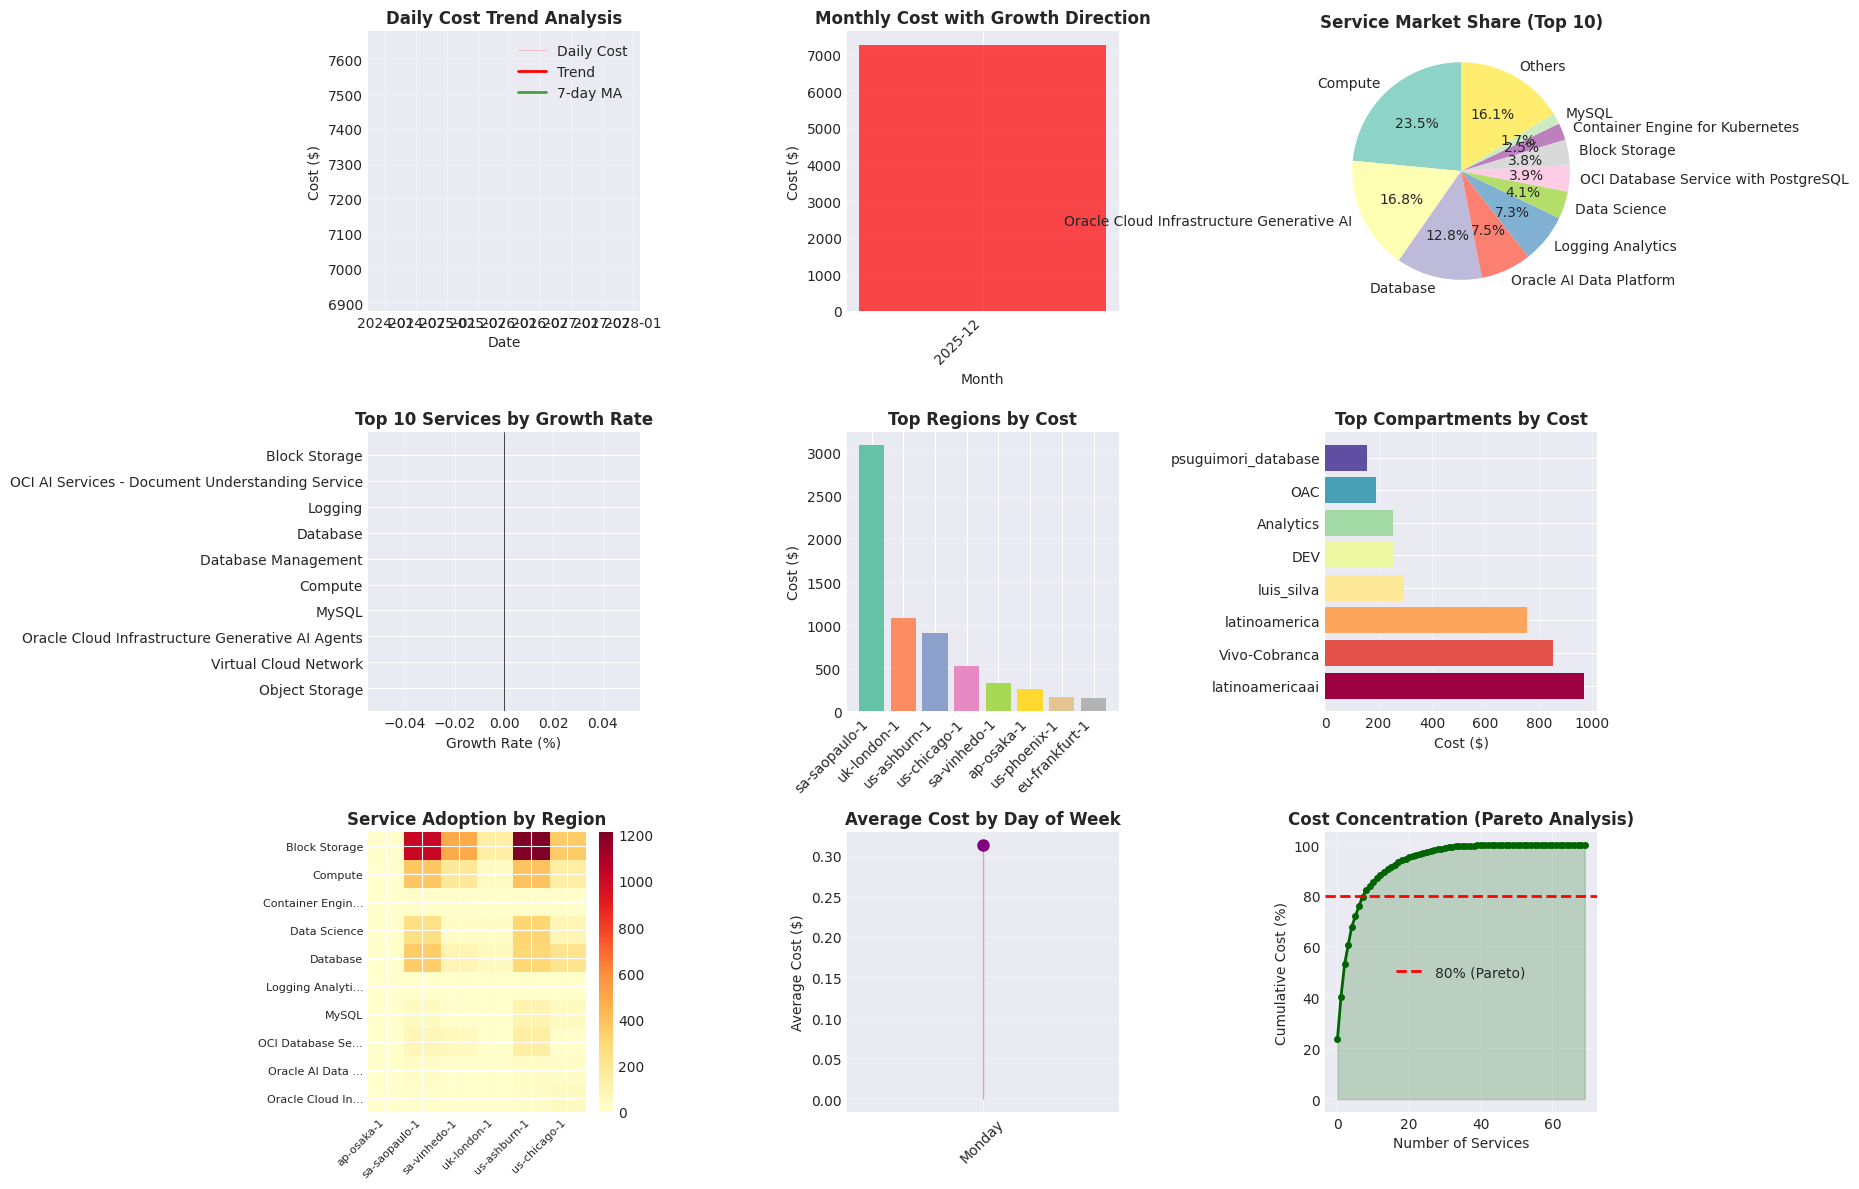

In [13]:
# Create comprehensive visualizations
fig = plt.figure(figsize=(18, 12))

# 1. Daily cost trend with moving average
ax1 = plt.subplot(3, 3, 1)
ax1.plot(daily_costs['date'], daily_costs['computedAmount'], label='Daily Cost', alpha=0.5, linewidth=0.5)
ax1.plot(daily_costs['date'], daily_costs['trend'], label='Trend', color='red', linewidth=2)
# Add 7-day moving average
ma_7 = daily_costs['computedAmount'].rolling(window=7).mean()
ax1.plot(daily_costs['date'], ma_7, label='7-day MA', color='green', linewidth=2, alpha=0.7)
ax1.set_title('Daily Cost Trend Analysis', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cost ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Monthly cost bar chart with growth rate
ax2 = plt.subplot(3, 3, 2)
months_display = monthly_costs['year_month'].tail(12).values
costs_display = monthly_costs['total_cost'].tail(12).values
colors = ['green' if x > 0 else 'red' for x in monthly_costs['mom_growth'].tail(12).values]
ax2.bar(range(len(months_display)), costs_display, color=colors, alpha=0.7)
ax2.set_title('Monthly Cost with Growth Direction', fontsize=12, fontweight='bold')
ax2.set_xlabel('Month')
ax2.set_ylabel('Cost ($)')
ax2.set_xticks(range(len(months_display)))
ax2.set_xticklabels(months_display, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Top 10 services pie chart
ax3 = plt.subplot(3, 3, 3)
top_10_services = service_summary.head(10)
other_cost = service_summary.iloc[10:]['total_cost'].sum()
pie_data = list(top_10_services['total_cost'].values)
pie_labels = list(top_10_services['service'].values)
if other_cost > 0:
    pie_data.append(other_cost)
    pie_labels.append('Others')
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(pie_data)))
ax3.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax3.set_title('Service Market Share (Top 10)', fontsize=12, fontweight='bold')

# 4. Service growth rates
ax4 = plt.subplot(3, 3, 4)
top_growth = growth_df.head(10).sort_values('growth_rate')
colors_growth = ['green' if x > 0 else 'red' for x in top_growth['growth_rate'].values]
ax4.barh(range(len(top_growth)), top_growth['growth_rate'].values, color=colors_growth, alpha=0.7)
ax4.set_yticks(range(len(top_growth)))
ax4.set_yticklabels(top_growth['service'].values)
ax4.set_xlabel('Growth Rate (%)')
ax4.set_title('Top 10 Services by Growth Rate', fontsize=12, fontweight='bold')
ax4.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax4.grid(True, alpha=0.3, axis='x')

# 5. Regional cost distribution
ax5 = plt.subplot(3, 3, 5)
top_regions = regional_analysis.head(8)
ax5.bar(range(len(top_regions)), top_regions['total_cost'].values, color=plt.cm.Set2(np.linspace(0, 1, len(top_regions))))
ax5.set_xticks(range(len(top_regions)))
ax5.set_xticklabels(top_regions['region'].values, rotation=45, ha='right')
ax5.set_ylabel('Cost ($)')
ax5.set_title('Top Regions by Cost', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# 6. Compartment cost distribution
ax6 = plt.subplot(3, 3, 6)
top_comps = compartment_analysis.head(8)
ax6.barh(range(len(top_comps)), top_comps['total_cost'].values, color=plt.cm.Spectral(np.linspace(0, 1, len(top_comps))))
ax6.set_yticks(range(len(top_comps)))
ax6.set_yticklabels([c[:30] + '...' if len(c) > 30 else c for c in top_comps['compartment'].values])
ax6.set_xlabel('Cost ($)')
ax6.set_title('Top Compartments by Cost', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='x')

# 7. Service adoption by region (heatmap style)
ax7 = plt.subplot(3, 3, 7)
service_region_matrix = df.groupby(['region', 'service']).size().unstack(fill_value=0)
top_regions_for_hm = regional_analysis.head(6)['region'].values
top_services_for_hm = service_summary.head(10)['service'].values
hm_data = service_region_matrix.loc[
    service_region_matrix.index.isin(top_regions_for_hm),
    service_region_matrix.columns.isin(top_services_for_hm)
]
im = ax7.imshow(hm_data.T, cmap='YlOrRd', aspect='auto')
ax7.set_xticks(range(len(hm_data)))
ax7.set_yticks(range(len(hm_data.columns)))
ax7.set_xticklabels(hm_data.index, rotation=45, ha='right', fontsize=8)
ax7.set_yticklabels([s[:15] + '...' if len(s) > 15 else s for s in hm_data.columns], fontsize=8)
ax7.set_title('Service Adoption by Region', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax7)

# 8. Cost distribution by day of week
ax8 = plt.subplot(3, 3, 8)
day_costs = df.groupby('day_of_week')['computedAmount'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax8.plot(day_costs.index, day_costs.values, marker='o', linewidth=2, markersize=8, color='purple')
ax8.fill_between(range(len(day_costs)), day_costs.values, alpha=0.3, color='purple')
ax8.set_ylabel('Average Cost ($)')
ax8.set_title('Average Cost by Day of Week', fontsize=12, fontweight='bold')
ax8.grid(True, alpha=0.3)
ax8.tick_params(axis='x', rotation=45)

# 9. Cost concentration (Pareto principle)
ax9 = plt.subplot(3, 3, 9)
service_costs_sorted = service_summary['total_cost'].sort_values(ascending=False).reset_index(drop=True)
cumsum = service_costs_sorted.cumsum() / service_costs_sorted.sum() * 100
ax9.plot(range(len(cumsum)), cumsum.values, marker='o', linewidth=2, color='darkgreen', markersize=4)
ax9.axhline(y=80, color='red', linestyle='--', linewidth=2, label='80% (Pareto)')
ax9.fill_between(range(len(cumsum)), cumsum.values, alpha=0.2, color='darkgreen')
ax9.set_xlabel('Number of Services')
ax9.set_ylabel('Cumulative Cost (%)')
ax9.set_title('Cost Concentration (Pareto Analysis)', fontsize=12, fontweight='bold')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/growth_trends_analysis_dashboard.png', dpi=300, bbox_inches='tight')
print("✅ Main Dashboard saved as 'growth_trends_analysis_dashboard.png'")
plt.show()

✅ Top Services Trends saved as 'top_services_detailed_trends.png'


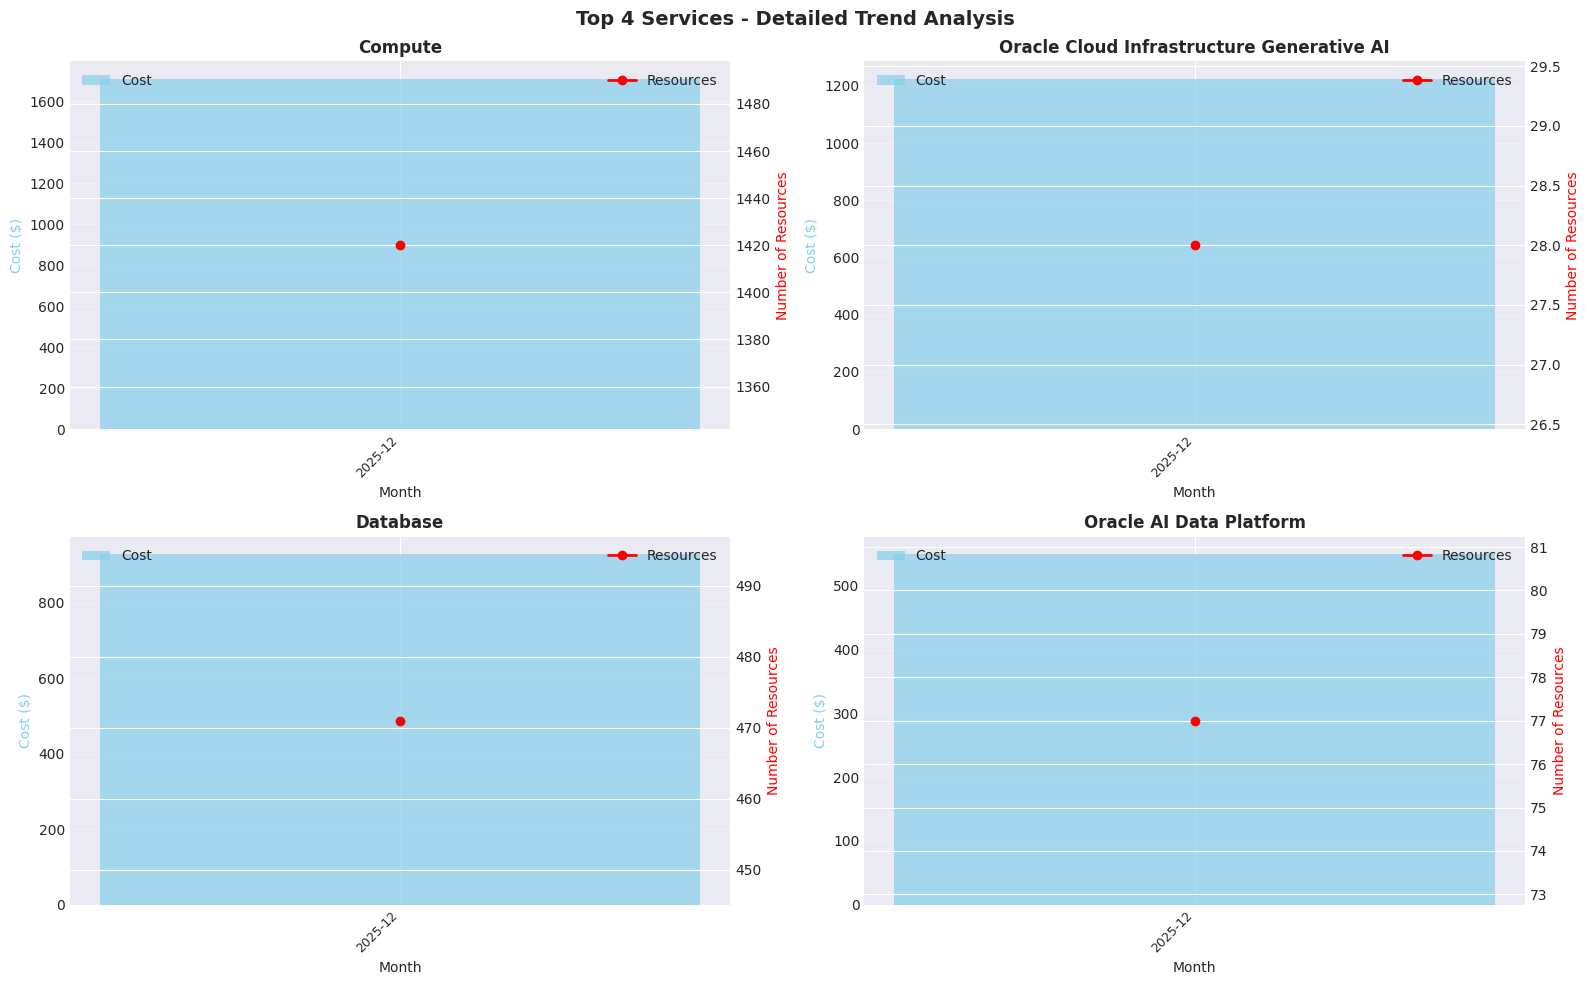

In [14]:
# Additional detailed visualizations for specific insights

# Visualization 2: Service-level trends for top services
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Top 4 Services - Detailed Trend Analysis', fontsize=14, fontweight='bold')

top_4_services = service_summary.head(4)['service'].values

for idx, (ax, service) in enumerate(zip(axes.flat, top_4_services)):
    service_monthly = df[df['service'] == service].groupby('year_month').agg({
        'computedAmount': 'sum',
        'resourceId': 'nunique',
        'computedQuantity': 'sum'
    }).reset_index()
    
    ax2 = ax.twinx()
    
    # Bar chart for cost
    ax.bar(range(len(service_monthly)), service_monthly['computedAmount'].values, 
           color='skyblue', alpha=0.7, label='Cost')
    
    # Line chart for resource count
    ax2.plot(range(len(service_monthly)), service_monthly['resourceId'].values, 
            marker='o', color='red', linewidth=2, markersize=6, label='Resources')
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Cost ($)', color='skyblue')
    ax2.set_ylabel('Number of Resources', color='red')
    ax.set_title(f'{service}', fontweight='bold')
    ax.set_xticks(range(len(service_monthly)))
    ax.set_xticklabels(service_monthly['year_month'].values, rotation=45, ha='right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add legends
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('../output/top_services_detailed_trends.png', dpi=300, bbox_inches='tight')
print("✅ Top Services Trends saved as 'top_services_detailed_trends.png'")
plt.show()

✅ Regional Analysis saved as 'regional_growth_analysis.png'


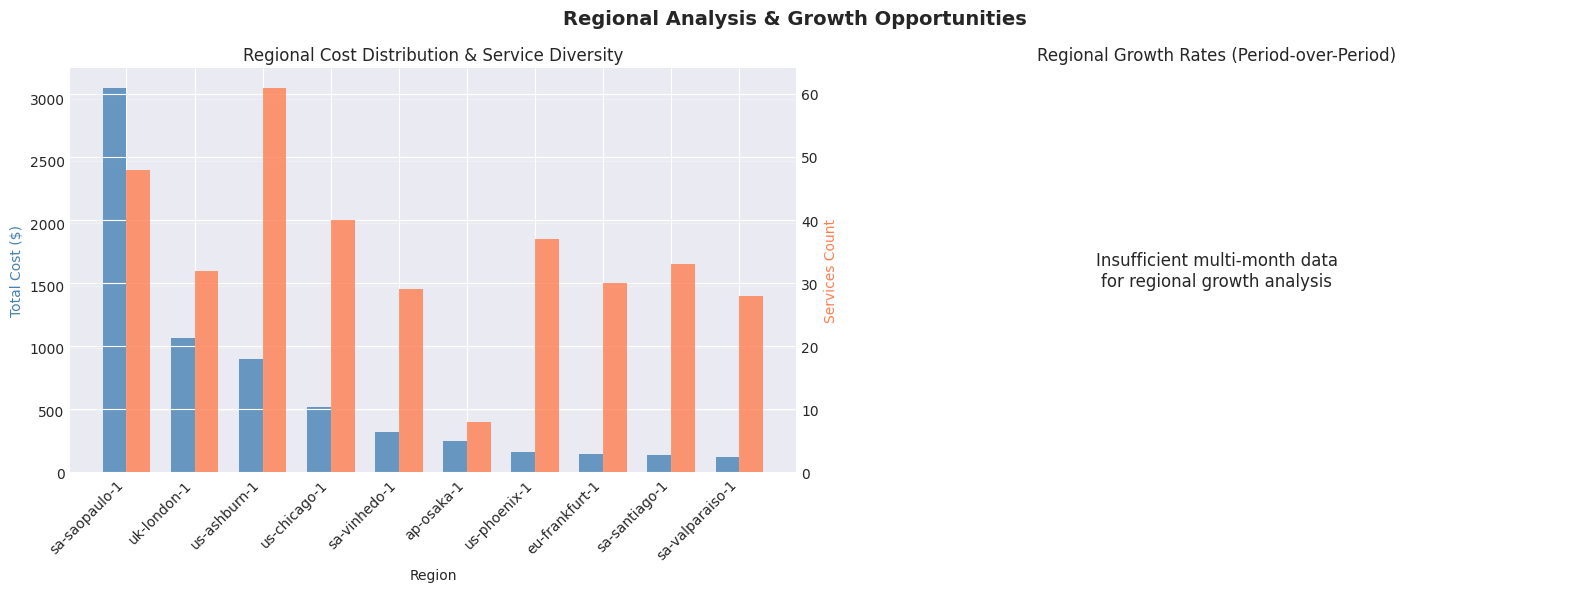

In [16]:
# Regional growth analysis visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Regional Analysis & Growth Opportunities', fontsize=14, fontweight='bold')

# Regional cost and service adoption
ax1 = axes[0]
top_regions_detail = regional_analysis.head(10)
x_pos = np.arange(len(top_regions_detail))
width = 0.35

ax1_bar = ax1.bar(x_pos - width/2, top_regions_detail['total_cost'].values, width, 
                   label='Total Cost', color='steelblue', alpha=0.8)
ax1_twin = ax1.twinx()
ax1_twin.bar(x_pos + width/2, top_regions_detail['num_services'].values, width,
             label='Number of Services', color='coral', alpha=0.8)

ax1.set_xlabel('Region')
ax1.set_ylabel('Total Cost ($)', color='steelblue')
ax1_twin.set_ylabel('Services Count', color='coral')
ax1.set_title('Regional Cost Distribution & Service Diversity')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(top_regions_detail['region'].values, rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')

# Regional growth rates
ax2 = axes[1]
# Check if regional_growth_df exists and has data
if 'regional_growth_df' in locals() and len(regional_growth_df) > 0:
    regional_growth_display = regional_growth_df.head(10).sort_values('growth_rate')
    colors_reg = ['green' if x > 0 else 'red' for x in regional_growth_display['growth_rate'].values]
    ax2.barh(range(len(regional_growth_display)), regional_growth_display['growth_rate'].values, 
             color=colors_reg, alpha=0.7)
    ax2.set_yticks(range(len(regional_growth_display)))
    ax2.set_yticklabels(regional_growth_display['region'].values)
    ax2.set_xlabel('Growth Rate (%)')
    ax2.set_title('Regional Growth Rates (Period-over-Period)')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax2.grid(True, alpha=0.3, axis='x')
else:
    ax2.text(0.5, 0.5, 'Insufficient multi-month data\nfor regional growth analysis', 
             ha='center', va='center', fontsize=12, transform=ax2.transAxes)
    ax2.set_title('Regional Growth Rates (Period-over-Period)')
    ax2.axis('off')

plt.tight_layout()
plt.savefig('../output/regional_growth_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Regional Analysis saved as 'regional_growth_analysis.png'")
plt.show()

In [17]:
# Create a summary report as dataframe export
print("\n" + "="*80)
print("EXECUTIVE SUMMARY - KEY METRICS")
print("="*80)

summary_metrics = {
    'Metric': [
        'Total Historical Cost',
        'Total Transactions',
        'Average Transaction Size',
        'Daily Average Cost',
        'Monthly Average Cost',
        'Current Daily Cost',
        'Current Month Cost (partial)',
        '',
        'Unique Services',
        'Unique Regions',
        'Unique Compartments',
        'Unique Resources',
        '',
        'Overall Growth Rate (daily)',
        'Overall Growth Rate (annualized)',
        'Recent MoM Growth',
        'Growth Momentum',
        '',
        'Top Service Market Share',
        'Top 3 Services Market Share',
        'Top 5 Services Market Share',
        '',
        'Services with Positive Growth',
        'Services with Negative Growth',
        'High-Growth Services (>20%)',
        'Emerging Services (<60 days)',
    ],
    'Value': [
        f"${df['computedAmount'].sum():,.2f}",
        f"{len(df):,}",
        f"${df['computedAmount'].mean():,.2f}",
        f"${daily_costs['computedAmount'].mean():,.2f}",
        f"${monthly_costs['total_cost'].mean():,.2f}",
        f"${daily_costs['computedAmount'].iloc[-1]:,.2f}",
        f"${monthly_costs['total_cost'].iloc[-1]:,.2f}",
        '',
        f"{df['service'].nunique()}",
        f"{df['region'].nunique()}",
        f"{df['compartmentName'].nunique()}",
        f"{df['resourceId'].nunique()}",
        '',
        f"{daily_growth_rate:.3f}%",
        f"{daily_growth_rate * 365:.2f}%",
        f"{recent_mom:.2f}%",
        f"{'🚀 Accelerating' if acceleration > 0 else '⬇️ Decelerating' if acceleration < 0 else '➡️ Stable'}",
        '',
        f"{service_summary.iloc[0]['market_share']:.1f}%",
        f"{service_summary.head(3)['market_share'].sum():.1f}%",
        f"{service_summary.head(5)['market_share'].sum():.1f}%",
        '',
        f"{len(growth_df[growth_df['growth_rate'] > 0])}",
        f"{len(growth_df[growth_df['growth_rate'] < 0])}",
        f"{len(high_growth)}",
        f"{len(emerging) if 'emerging' in locals() else 0}",
    ]
}

summary_df = pd.DataFrame(summary_metrics)
print("\n" + summary_df.to_string(index=False))

# Export key datasets to CSV for further analysis
print("\n" + "="*80)
print("EXPORTING ANALYSIS RESULTS TO CSV")
print("="*80)

# Export monthly trends
monthly_export = monthly_costs[['year_month', 'total_cost', 'num_services', 'num_regions', 'mom_growth']]
monthly_export.to_csv('../output/growth_analysis_monthly_trends.csv', index=False)
print("✅ Monthly trends exported: growth_analysis_monthly_trends.csv")

# Export service analysis
service_export = service_summary[['rank', 'service', 'total_cost', 'market_share', 'num_resources', 'avg_cost_per_row']]
service_export.to_csv('../output/growth_analysis_service_breakdown.csv', index=False)
print("✅ Service breakdown exported: growth_analysis_service_breakdown.csv")

# Export growth analysis
growth_export = growth_df[['service', 'total_cost', 'current_monthly', 'growth_rate', 'num_resources', 'market_share']]
growth_export.to_csv('../output/growth_analysis_service_growth_rates.csv', index=False)
print("✅ Service growth rates exported: growth_analysis_service_growth_rates.csv")

# Export regional analysis
regional_export = regional_analysis[['region', 'total_cost', 'market_share', 'num_services', 'num_resources']]
regional_export.to_csv('../output/growth_analysis_regional_breakdown.csv', index=False)
print("✅ Regional analysis exported: growth_analysis_regional_breakdown.csv")

# Export compartment analysis
compartment_export = compartment_analysis[['compartment', 'total_cost', 'market_share', 'num_services', 'num_resources']]
compartment_export.to_csv('../output/growth_analysis_compartment_breakdown.csv', index=False)
print("✅ Compartment analysis exported: growth_analysis_compartment_breakdown.csv")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"\n✅ All visualizations and exports have been saved to ../output/")
print(f"📊 Open the generated CSV files for detailed reporting and further analysis")
print(f"📈 Share the PNG visualizations with stakeholders for decision-making")


EXECUTIVE SUMMARY - KEY METRICS

                          Metric     Value
           Total Historical Cost $7,279.36
              Total Transactions    23,235
        Average Transaction Size     $0.31
              Daily Average Cost $7,279.36
            Monthly Average Cost $7,279.36
              Current Daily Cost $7,279.36
    Current Month Cost (partial) $7,279.36
                                          
                 Unique Services        70
                  Unique Regions        24
             Unique Compartments       818
                Unique Resources     14162
                                          
     Overall Growth Rate (daily)    0.000%
Overall Growth Rate (annualized)     0.00%
               Recent MoM Growth      nan%
                 Growth Momentum ➡️ Stable
                                          
        Top Service Market Share     23.5%
     Top 3 Services Market Share     53.1%
     Top 5 Services Market Share     67.9%
                    